In [1]:
import os
from pathlib import Path
import git

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
CWD = os.getcwd()
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
os.chdir(CWD)
np.random.seed(0)

In [99]:
points = [(0.2, -1), (4, 10), (0.2, 2), (10, 1)]
labels = ['A', 'B', 'C', 'D']

In [88]:
def visualize_prior_pdf(params, sample=[], log_scale = False, n_samples=1000, interval = None, debug=True, bw = 0.05, bw_log = 0.05, ax=None):
    """
    Visualize the gap between the empirical CDF/PDF and the Computed CDF/PDF.

    Args:
        sample (np.ndarray): Observed data.
        r (float): r value.
        eta (float): eta value.
        n_samples (int): Number of samples for the computed CDF/PDF.
        all_cdfs (dict): Dictionary containing computed CDFs.
        group (int or None): Group index (for titling purposes).

    Returns:
        distance (float): The Kolmogorov-Smirnov statistic.
        location (float): The location of the maximum deviation between the empirical and computed CDFs.
    """
    r, eta = params
    xs_pdf, null_cdf = compute_prior_cdf(r=r, eta=eta, n_samples=n_samples,  tail_bound=0.0001, enforce_assert=False, debug=debug, return_xs=True)
    null_pdf = null_cdf.derivative()(xs_pdf) 

    if log_scale:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

        # Empirical CDF vs Computed CDF
        ax1.set_xlim(left = -25, right = 25)
        if interval:
            ax1.set_xlim(left = interval[0], right = interval[1])
        ax1.plot(xs_pdf, null_pdf, label='Computed PDF')
        ax1.set_title(f'Prior (r={params[0]}, eta={params[1]})')
        ax1.set_title(f'Log Scale: Prior (r={params[0]}, eta={params[1]})')

        # Log Scale
        ax2.set_xlim(left = -25, right = 25)
        if interval:
            ax2.set_xlim(left = interval[0], right = interval[1])
        ax2.set_ylim(bottom = 10**-4, top=10)
        sns.kdeplot(ax = ax2, x = sample, bw_method = bw, log_scale=[False, True], label = f"Empirical PDF (KDE, bw={bw_log})")
        ax2.plot(xs_pdf, null_pdf, label = "Computed PDF")

        ax1.legend()
        ax2.legend()

        plt.tight_layout()
        plt.show()    
        
    else:
        fig, ax1 = plt.subplots(1, 1, figsize=(8, 6))

        # Empirical CDF vs Computed CDF
        ax1.set_xlim(left = -25, right = 25)
        if interval:
            ax1.set_xlim(left = interval[0], right = interval[1])
        ax1.plot(xs_pdf, null_pdf, label='Computed PDF')
        ax1.set_title(f'Prior (r={params[0]}, eta={params[1]})')
        #ax1.legend()
        plt.tight_layout()
        plt.show() 

    return fig

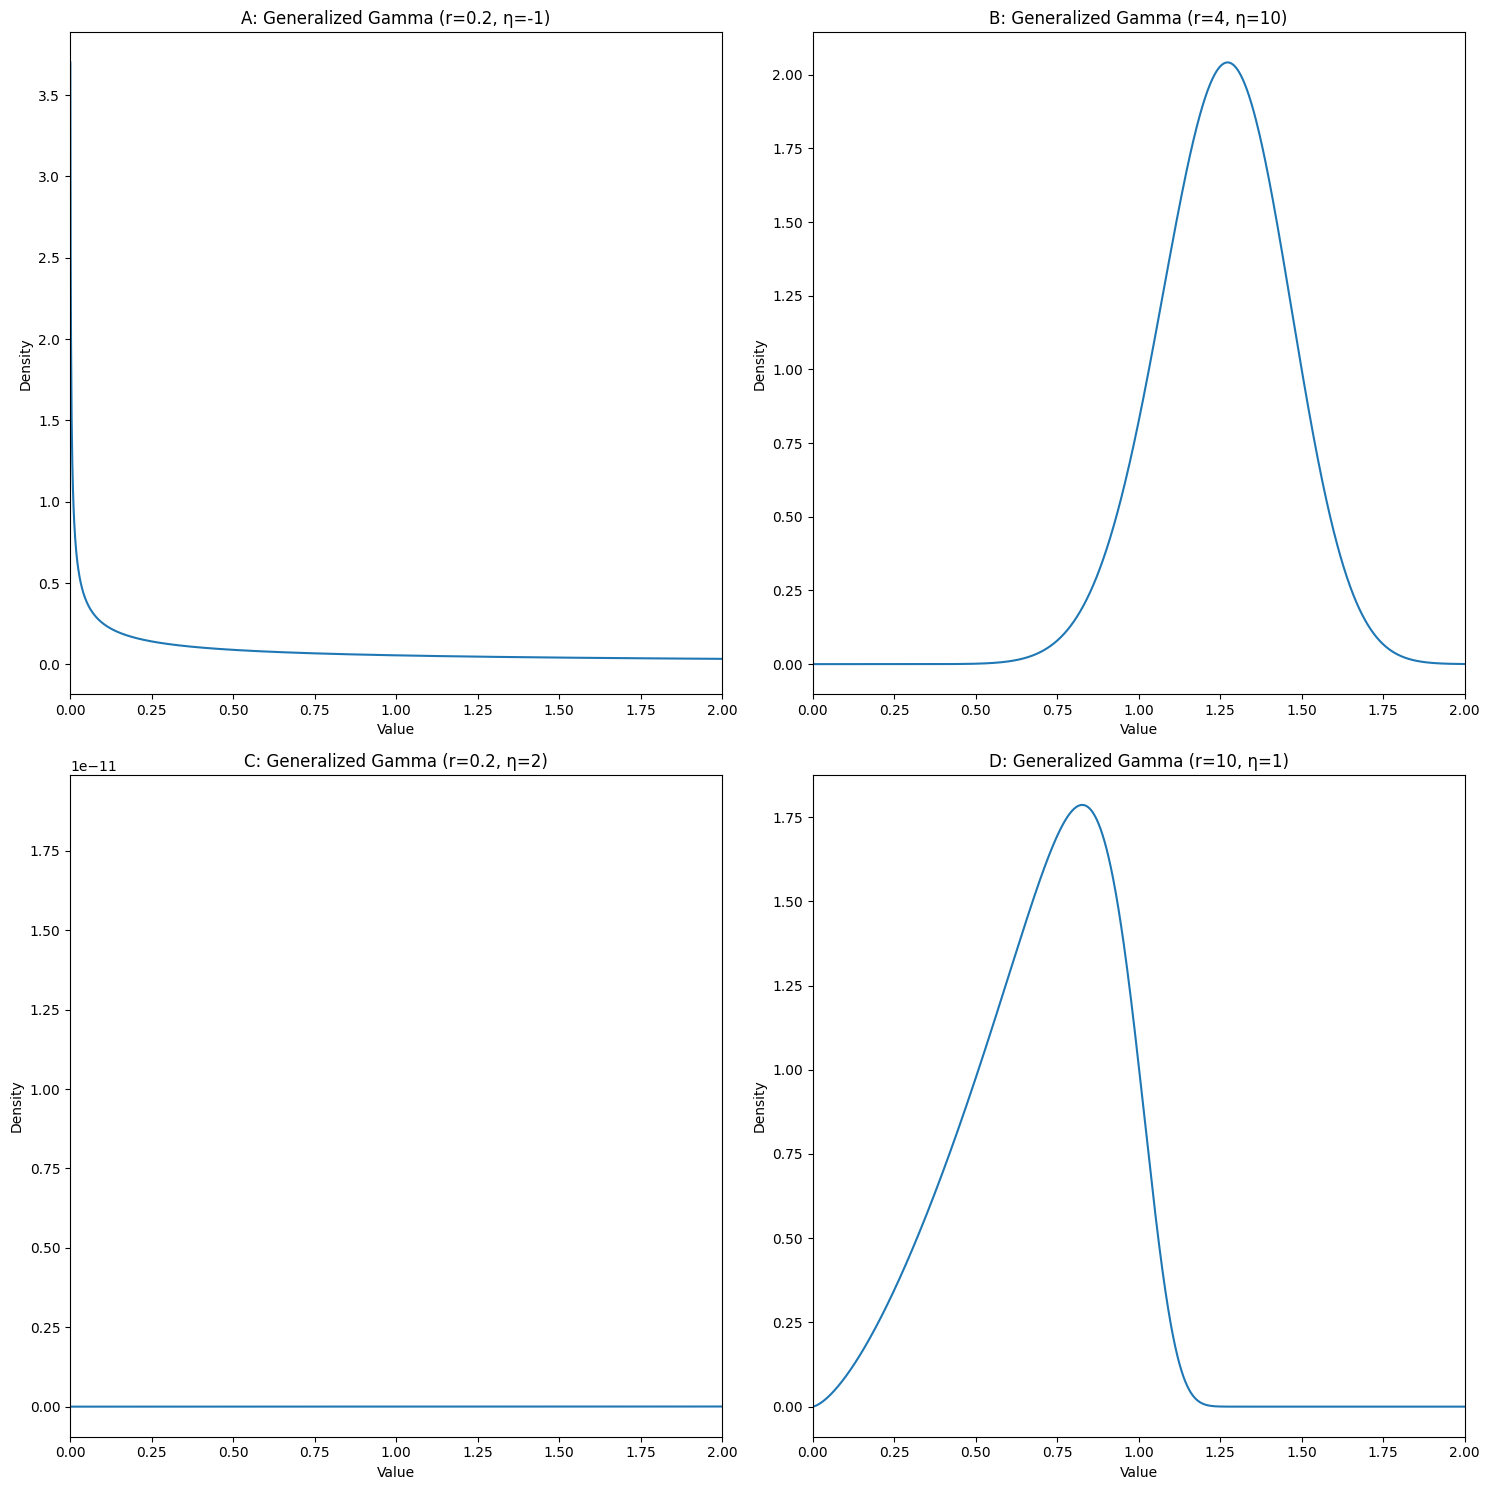

In [ ]:
def visualize_gamma_grid(points, labels, xlim=(0, 2)):
    """
    Visualize multiple generalized gamma distributions in a 2x2 grid.
    
    Args:
        points (list): List of (r, eta) tuples for each distribution
        labels (list): List of labels corresponding to each distribution
        xlim (tuple): x-axis limits (min, max)
    
    Returns:
        matplotlib.figure.Figure: The generated figure
    """
    # Create a 2x2 subplot grid
    fig, axes = plt.subplots(2, 2, figsize=(15, 15))
    axes = axes.ravel()  # Flatten axes array for easier indexing
    
    # Generate x values
    xs = np.linspace(0, 100, 100000)
    
    # Plot each distribution
    for i in range(4):
        r, eta = points[i]
        beta = (eta + 1.5)/r
        
        # Calculate PDF
        pdf = stats.gengamma.pdf(xs, a=beta, c=r)
        
        # Plot on corresponding subplot
        axes[i].plot(xs, pdf)
        axes[i].set_title(f'{labels[i]}: Generalized Gamma (r={r}, η={eta})')
        axes[i].set_xlim(xlim)
        axes[i].set_xlabel('Value')
        axes[i].set_ylabel('Density')
        
    plt.tight_layout()
    return fig

fig = visualize_gamma_grid(points, labels)
plt.show()

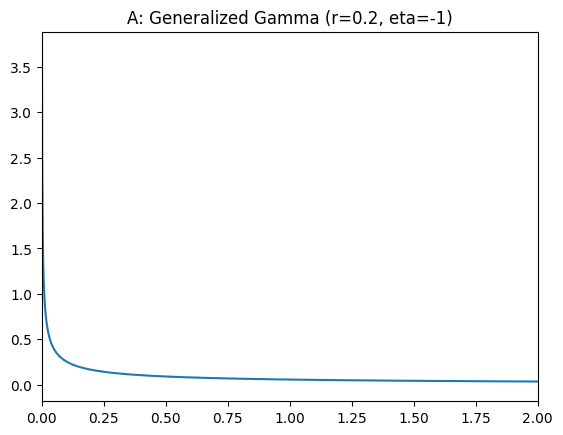

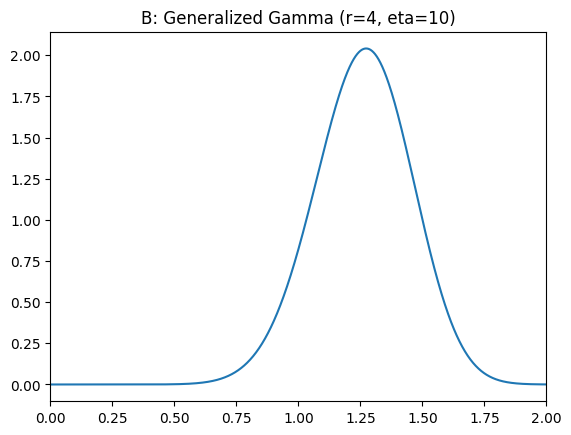

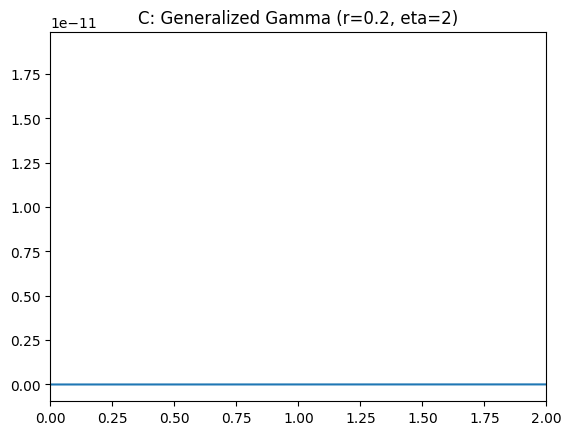

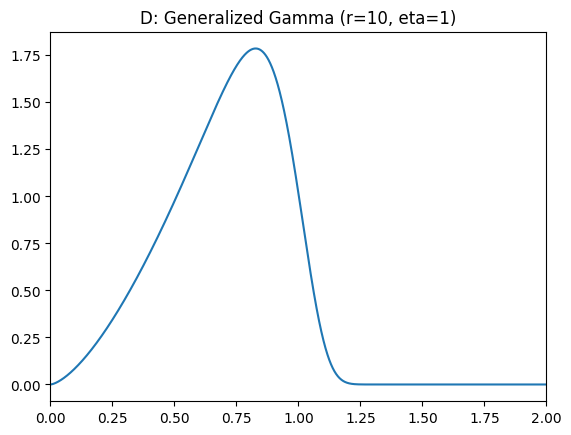

In [101]:
for i in range(4):
    xs = np.linspace(0, 100, 100000)
    r, eta = points[i]
    beta = (eta + 1.5)/r 
    
    pdf = stats.gengamma.pdf(xs, a = beta, c = r)
    plt.plot(xs, pdf)
    plt.title(f'{labels[i]}: Generalized Gamma (r={points[i][0]}, eta={points[i][1]})')
    plt.xlim(0, 2)
    plt.show()

C:\Users\yashd\AppData\Local\Temp\ipykernel_67296\1603219545.py:2: RuntimeWarning: invalid value encountered in scalar divide
  return scipy.special.gamma((eta+2.5)/r) / scipy.special.gamma((eta+1.5)/r)
c:\Users\yashd\.conda\envs\hbmv_backup2\Lib\site-packages\scipy\optimize\_optimize.py:2973: RuntimeWarning: invalid value encountered in scalar divide
  w = xb - ((xb - xc) * tmp2 - (xb - xa) * tmp1) / denom
C:\Users\yashd\AppData\Local\Temp\ipykernel_67296\1603219545.py:96: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + [str(int(x)) for x in ax.get_xticks()[1:]])


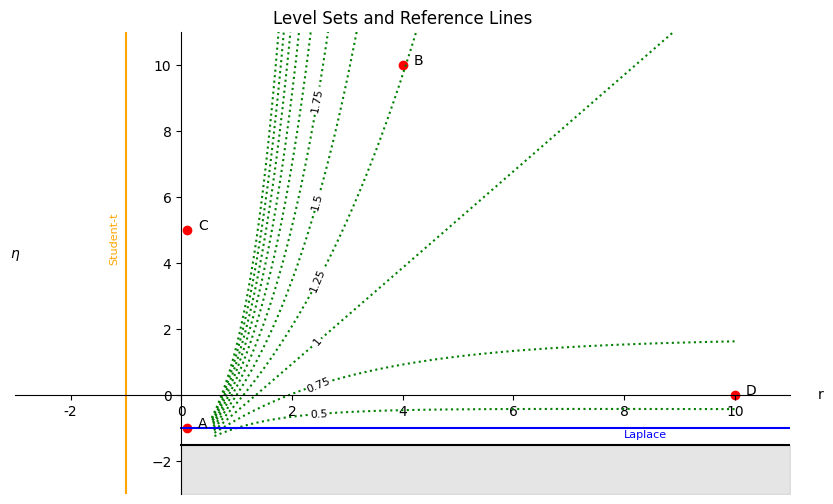

In [4]:
def gen_gamma_mean(r, eta):
    return scipy.special.gamma((eta+2.5)/r) / scipy.special.gamma((eta+1.5)/r)

def find_eta_for_target_var(r, target_var):
    def objective(eta):
        return (gen_gamma_mean(r, eta) - target_var)**2
    result = scipy.optimize.minimize_scalar(objective)
    return result.x

def get_level_set(target_var, k=50):
    r_vals, eta_vals = [], []
    for r in np.linspace(0.01, 10, 1000):
        eta = find_eta_for_target_var(r, target_var)
        r_vals.append(r)
        eta_vals.append(eta)
    return r_vals[k:], eta_vals[k:]

x_left, x_right = -3, 11
y_down, y_up = -3, 11
points = [(0.1, -1), (4, 10), (0.1, 5), (10, 0)]
labels = ['A', 'B', 'C', 'D']

fig, ax = plt.subplots(figsize=(10, 6))

# Add shaded region for eta <= 1.5, r > 0
x_shade = np.array([0, x_right])
y_shade = np.array([-1.5, -1.5])
ax.fill_between(x_shade, y_down, y_shade, color='grey', alpha=0.2)
ax.plot(x_shade, y_shade, 'k-', linewidth=1.5)

# Plot level sets
target_vars = [0.5, 0.75, 1, 1.25, 1.5, 1.75, 2, 2.25, 2.5, 2.75, 3]
for target_var in target_vars:
    r_vals, eta_vals = get_level_set(target_var, k=60 - int(2*target_var))
    
    # Calculate break point for the line
    mid_idx = len(r_vals) // 5
    break_start = mid_idx - int(5/target_var)
    break_end = mid_idx + int(5/target_var)
    
    # Plot the line in segments to create a break
    ax.plot(r_vals[:break_start], eta_vals[:break_start], linestyle='dotted', c='green')
    ax.plot(r_vals[break_end:], eta_vals[break_end:], linestyle='dotted', c='green')
    
    # Calculate angle for text alignment
    if mid_idx + 1 < len(r_vals):
        dx = r_vals[mid_idx + 1] - r_vals[mid_idx]
        dy = eta_vals[mid_idx + 1] - eta_vals[mid_idx]
        angle = np.degrees(np.arctan2(dy, dx)) - 5
    else:
        angle = 0
    
    # Add label with white background
    ax.annotate(f'{target_var}', 
                (r_vals[mid_idx], eta_vals[mid_idx]),
                xytext=(0, 0), textcoords='offset points',
                fontsize=8, rotation=angle,
                va='center', ha='center',
                bbox=dict(facecolor='white', edgecolor='none', pad=0.5))

# Add Student-t and Laplace lines with direct labels
ax.axvline(-1, color='orange', linewidth=1.5, label = 'Student t')
ax.axhline(-1, xmin=np.abs(x_left/(x_right - x_left)), xmax=1, color='blue', linewidth=1.5, label = 'Laplace')

# Add direct labels on the plot
ax.text(8, -1.3, 'Laplace', color='blue', fontsize=8)
ax.text(-1.3, 4, 'Student-t', color='orange', fontsize=8, rotation=90)

# Add arrows to axes
ax.spines['left'].set_position('zero')
ax.spines['bottom'].set_position('zero')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)


# Fix origin tick mark to show only once
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.yaxis.set_label_coords(0, 1.02)

# Set axes labels with LaTeX
ax.text(x_right + 0.5, 0, 'r', ha='left', va='center')
ax.set_ylabel(r'$\eta$', rotation=0)

# Plot and label points
for (x, y), label in zip(points, labels):
    ax.scatter(x, y, color='red')
    ax.text(x + 0.2, y, label, color='black', fontsize=10)

# Customize the plot
ax.set_xlim(x_left, x_right)
ax.set_ylim(y_down, y_up)
ax.set_title('Level Sets and Reference Lines')

# Ensure only one '0' shows at origin
ax.set_xticklabels([''] + [str(int(x)) for x in ax.get_xticks()[1:]])
#plt.legend()
plt.show()